<h1>Forecasting Test 1<h1>

<h4>Data Cleaning<h4>

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import KFold
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

df = pd.read_csv('.\Datasets\CR_COST_FC_new.csv', converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})
df['POD'] = pd.to_datetime(df['POD'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
df = df.dropna(subset=['ENCODED_TYPE'])
df['RATE'] = df['RATE'].fillna(-1).astype(int)
df = df.dropna(subset=['RATE'])
df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)

# Remove NAN values
df_clean= df.dropna().reset_index(drop=True)

df_clean.head()
df_clean.info()
print(f'Dataset size: {df_clean.shape}')

,COM_ID,PARTY_ID,PARTY_ID_EN,PARTY_NAME,CSL_ID,ETA_ETD_NO,ETD_POL_D,POD_ID,POD,CNTR_ID,CNTR_SIZE,CNTR_TYPE,COST_TERM,RATE,ENCODED_TYPE,ENCODED_TERM,POD_ID_EN
0,010,010003678,10003678,OY TAVATUR SHIPPING LTD,ECS010060100191,20060228,FIHEL,HELSINKI,2006-02-28,CTNR010060201232,20,GP,FC,675,2,1,4.103561e+09
1,010,010004286,10004286,"GLOBELINK KOREA CO., LTD",ECS010060100465,20060303,KRPUS,BUSAN,2006-03-03,CTNR010060300014,40,HC,FC,390,1,1,2.904902e+09
2,010,01005136,1005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,ECS010060100321,20060227,NZAKL,AUCKLAND,2006-02-27,CTNR010060201198,40,HC NOR,FC,1615,4,1,2.397848e+09
3,010,01002775,1002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,ECS010060200201,20060306,AUADL,ADELAIDE,2006-03-06,CTNR010060300119,40,HC,FC,700,1,1,2.480737e+08
4,010,01001088,1001088,CARGO LINES S.A.-LE HAVRE,ECS010060200146,20060307,FRMRS,MARSEILLE,2006-03-07,CTNR010060300185,20,GP,FC,675,2,1,4.197227e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   COM_ID        54722 non-null  object        
 1   PARTY_ID      54722 non-null  object        
 2   PARTY_ID_EN   54722 non-null  int64         
 3   PARTY_NAME    54722 non-null  object        
 4   CSL_ID        54722 non-null  object        
 5   ETA_ETD_NO    54722 non-null  int64         
 6   ETD_POL_D     54722 non-null  object        
 7   POD_ID        54722 non-null  object        
 8   POD           54722 non-null  datetime64[ns]
 9   CNTR_ID       54722 non-null  object        
 10  CNTR_SIZE     54722 non-null  object        
 11  CNTR_TYPE     54722 non-null  object        
 12  COST_TERM     54722 non-null  object        
 13  RATE          54722 non-null  int32         
 14  ENCODED_TYPE  54722 non-null  int32         
 15  ENCODED_TERM  54722 non-null  int64 

In [171]:
sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
           'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']

df_fc = df_clean[sel_col]
df_fc.head()
df_fc.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54722 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54722 non-null  object        
 1   CNTR_ID     54722 non-null  object        
 2   POD_ID      54722 non-null  object        
 3   ETD_POL_D   54722 non-null  object        
 4   PARTY_ID    54722 non-null  object        
 5   PARTY_NAME  54722 non-null  object        
 6   POD         54722 non-null  datetime64[ns]
 7   CNTR_SIZE   54722 non-null  object        
 8   CNTR_TYPE   54722 non-null  object        
 9   RATE        54722 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.0+ MB


In [172]:
# filter out rows where the year is 2002
df_filtered = df_fc[df_fc['POD'].dt.year != 2002]
df_filtered.head()
df_filtered.info()

# Checking if year 2002 is removed
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010060100191,CTNR010060201232,HELSINKI,FIHEL,010003678,OY TAVATUR SHIPPING LTD,2006-02-28,20,GP,675
1,ECS010060100465,CTNR010060300014,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2006-03-03,40,HC,390
2,ECS010060100321,CTNR010060201198,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2006-02-27,40,HC NOR,1615
3,ECS010060200201,CTNR010060300119,ADELAIDE,AUADL,01002775,GLOBELINK INTERNATIONAL PTY LTD-ADELAIDE,2006-03-06,40,HC,700
4,ECS010060200146,CTNR010060300185,MARSEILLE,FRMRS,01001088,CARGO LINES S.A.-LE HAVRE,2006-03-07,20,GP,675


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54721 entries, 0 to 54721
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      54721 non-null  object        
 1   CNTR_ID     54721 non-null  object        
 2   POD_ID      54721 non-null  object        
 3   ETD_POL_D   54721 non-null  object        
 4   PARTY_ID    54721 non-null  object        
 5   PARTY_NAME  54721 non-null  object        
 6   POD         54721 non-null  datetime64[ns]
 7   CNTR_SIZE   54721 non-null  object        
 8   CNTR_TYPE   54721 non-null  object        
 9   RATE        54721 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 4.4+ MB


array([2006, 2005, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2018, 2019, 2020, 2021, 2016, 2017, 2022, 2023], dtype=int64)

In [173]:
# Sorting the dates 
df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
df_filtered.head()
df_filtered.tail()
df_filtered['POD'].dt.year.unique()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
54716,ECS010230400526,010000573399,VALPARAISO,CLVAP,010006350,CRAFT MULTIMODAL CHILE SPA,2023-05-24,40,HC,1300
54717,ECS010230400525,010000582631,CALLAO,PECLL,010026711,CRAFT MULTIMODAL PERU S.A,2023-05-24,40,HC NOR,1300
54718,ECS010230400452,010000580585,BUENOS AIRES,ARBUE,010006300,CRAFT ARGENTINA SA,2023-05-25,40,HC,2300
54719,ECS010230400451,010000554136,MONTEVIDEO,UYMVD,010021385,CRAFT URUGUAY CHEBURIN S.A,2023-05-25,40,HC,1100
54720,ECS010230400352,010000588769,ASHDOD,ILASH,010008035,MAYAN OVERSEAS LTD,2023-05-27,20,GP,2100


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

<h4>FIltering and getting a list stored as a dictionary</h4>

In [174]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [175]:
filtered_dataframes = filter_dataframe(df_filtered)

# Show case some samples of keys
df_ids = list(filtered_dataframes.keys())
print(list(df_ids))
print(len(list(df_ids)))

['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100028193', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_Party

<h4>Getting the top 5 ports</h4>

In [176]:
# Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
key_row_counts = {key: len(filtered_dataframes[key]) for key in filtered_dataframes}

# Sort the key_row_counts dictionary by value (number of rows) in descending order
sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)
# print(sorted_key_row_counts)

# Get the top 5 keys with the most rows
top_5_keys_tuple = sorted_key_row_counts[:5]
# print(top_5_keys_tuple)

# Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
filtered_dataframes_subset = {}

for key, row_count in top_5_keys_tuple:
    filtered_dataframes_subset[key] = filtered_dataframes[key][:5]
    print(f"Number of rows in {key}: {row_count}")

# print(filtered_dataframes_subset.keys())

Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [177]:
# Selected dataframe
sel_df = filtered_dataframes['Port_BUSAN_Size_40_Type_HC_PartyID_010004286']
sel_df.head()
sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 140.4+ KB


In [178]:
# Check for duplicates and keep only one instance of each unique combination
sel_df = sel_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)
sel_df.info()
sel_df.head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1139 non-null   object        
 1   CNTR_ID     1139 non-null   object        
 2   POD_ID      1139 non-null   object        
 3   ETD_POL_D   1139 non-null   object        
 4   PARTY_ID    1139 non-null   object        
 5   PARTY_NAME  1139 non-null   object        
 6   POD         1139 non-null   datetime64[ns]
 7   CNTR_SIZE   1139 non-null   object        
 8   CNTR_TYPE   1139 non-null   object        
 9   RATE        1139 non-null   int32         
dtypes: datetime64[ns](1), int32(1), object(8)
memory usage: 84.7+ KB


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390
1,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390
2,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390
3,ECS010050900471,CTNR010051001330,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-30,40,HC,390
4,ECS010051000380,CTNR010051001332,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-03,40,HC,390
5,ECS010051000381,CTNR010051100185,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-12,40,HC,390
6,ECS010051000382,CTNR010051101339,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-11-28,40,HC,390
7,ECS010051100223,CTNR010051101279,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-04,40,HC,390
8,ECS010051100224,CTNR010051200319,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-10,40,HC,390
9,ECS010051100227,CTNR010051201287,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-12-31,40,HC,390


In [179]:
# Initialize the reference date with the first date in the "POD" column
reference_date = sel_df['POD'].iloc[0]

# Calculate the difference in days and print it out
for index, date in enumerate(sel_df['POD']):
    if index > 0:
        prev_date = sel_df['POD'].iloc[index - 1]
        days_difference = (date - prev_date).days
        print(f"Difference between {prev_date}and {date}: {days_difference} days")

Difference between 2005-10-03 00:00:00and 2005-10-07 00:00:00: 4 days
Difference between 2005-10-07 00:00:00and 2005-10-14 00:00:00: 7 days
Difference between 2005-10-14 00:00:00and 2005-10-30 00:00:00: 16 days
Difference between 2005-10-30 00:00:00and 2005-11-03 00:00:00: 4 days
Difference between 2005-11-03 00:00:00and 2005-11-12 00:00:00: 9 days
Difference between 2005-11-12 00:00:00and 2005-11-28 00:00:00: 16 days
Difference between 2005-11-28 00:00:00and 2005-12-04 00:00:00: 6 days
Difference between 2005-12-04 00:00:00and 2005-12-10 00:00:00: 6 days
Difference between 2005-12-10 00:00:00and 2005-12-31 00:00:00: 21 days
Difference between 2005-12-31 00:00:00and 2006-01-07 00:00:00: 7 days
Difference between 2006-01-07 00:00:00and 2006-02-04 00:00:00: 28 days
Difference between 2006-02-04 00:00:00and 2006-02-10 00:00:00: 6 days
Difference between 2006-02-10 00:00:00and 2006-02-17 00:00:00: 7 days
Difference between 2006-02-17 00:00:00and 2006-02-24 00:00:00: 7 days
Difference betwe

In [180]:
# Formating by month
# Create new dataframe for aggregated results
agg_df = pd.DataFrame(columns=['YearMonth', 'Year', 'Month', 'Rate'])

# Group by Year and Month
grouped = sel_df.groupby([sel_df['POD'].dt.year, sel_df['POD'].dt.month])

for group_name, group_df in grouped:
    year, month = group_name
    
    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()
    
    # Calculate mean or median based on skewness
    if rate_skew < 0:
        rate_metric = group_df['RATE'].mean()
    else:
        rate_metric = group_df['RATE'].median()
    
    new_row = {
        'YearMonth': pd.Timestamp(year=year, month=month, day=1),
        'Year': year,
        'Month': month,
        'Rate': rate_metric
    }
    
    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df.head(10)
agg_df.info()

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_14640\1960959433.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_14640\1960959433.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_14640\1960959433.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_14640\1960959433.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg

,YearMonth,Year,Month,Rate
0,2005-10-01,2005,10,390.0
1,2005-11-01,2005,11,390.0
2,2005-12-01,2005,12,390.0
3,2006-01-01,2006,1,390.0
4,2006-02-01,2006,2,390.0
5,2006-03-01,2006,3,385.0
6,2006-04-01,2006,4,380.0
7,2006-05-01,2006,5,380.0
8,2006-08-01,2006,8,380.0
9,2006-09-01,2006,9,380.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Year       185 non-null    object        
 2   Month      185 non-null    object        
 3   Rate       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.9+ KB


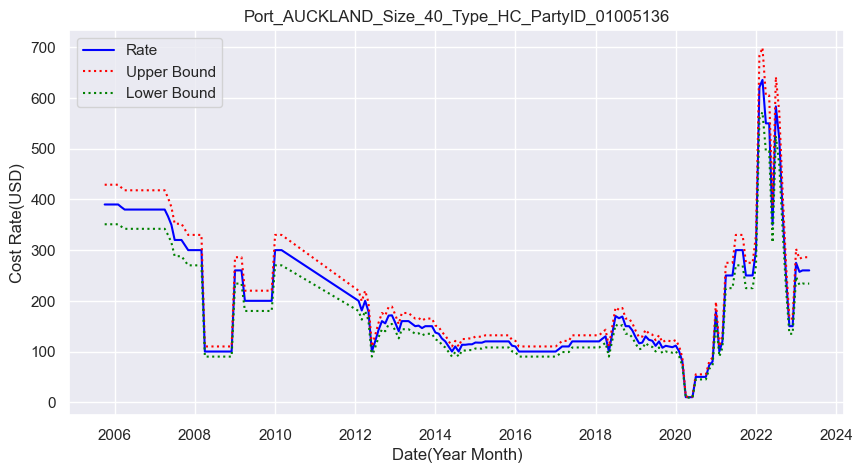

In [181]:
plt.figure(figsize=(10, 5))
plt.plot(agg_df['YearMonth'], agg_df['Rate'], color='blue', label='Rate')

# Calculate upper and lower bounds for aggr value for "Rate"
upper_bound = agg_df['Rate'] * 1.10
lower_bound = agg_df['Rate'] * 0.90

# Plot upper and lower bounds as dotted lines
plt.plot(agg_df['YearMonth'], upper_bound, linestyle='dotted', color='red', label='Upper Bound')
plt.plot(agg_df['YearMonth'], lower_bound, linestyle='dotted', color='green', label='Lower Bound')

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136')
plt.legend()
plt.show();


<h4>Modeling<h4>

In [182]:
mod_col = ['YearMonth','Rate']

df_fc = agg_df[mod_col]
df_fc.head()
df_fc.info()

,YearMonth,Rate
0,2005-10-01,390.0
1,2005-11-01,390.0
2,2005-12-01,390.0
3,2006-01-01,390.0
4,2006-02-01,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   YearMonth  185 non-null    datetime64[ns]
 1   Rate       185 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


Normalising 

In [189]:
# Setting up test and train set
X = df_fc.drop("Rate", axis=1)
Y = df_fc['Rate']

# Normalize the cost rate (Y)
scaler = StandardScaler()
Y_normalized = scaler.fit_transform(Y.values.reshape(-1, 1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_normalized, test_size=0.3, random_state=1)

In [184]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(129, 1)
(129, 1)
(56, 1)
(56, 1)


In [185]:
# Define Mean Square Error Function:
def compute_mse(y, y_hat):
    N = len(y) # Number of samples
    sqr_errors = [(y[i] - y_hat[i]) ** 2 for i in range(N)]
    mse = sum(sqr_errors) / N
    
    return mse

Regression Functions

In [192]:
# Got issue 

# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# def lstm_model(X_train, y_train, X_test, y_test):
    
#     print("X_train shape:", X_train.shape)
#     print("y_train shape:", y_train.shape)
#     print("X_test shape:", X_test.shape)
#     print("y_test shape:", y_test.shape)
    
#     # Create an LSTM model
#     model = Sequential()
#     model.add(LSTM(32, input_shape=(X_train.shape[1], 1)))
#     model.add(Dense(1))
    
#     # Compile the model
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
#     # Fit the model on the training data
#     model.fit(X_train, y_train, epochs=10, batch_size=32)
    
#     # Make predictions on the testing data
#     y_test_pred = model.predict(X_test)
    
#     # Calculate mean squared error on test data
#     mse_test = compute_mse(y_test, y_test_pred)
    
#     # Print the results
#     print("Mean Squared Error (Test):", mse_test)

# # Usage example:
# lstm_model(X_train, y_train, X_test, y_test)


LSTM Network:
1. Input Gate: decides which values from the input to update the memory state.
2. Forget Gate: handles what information to throw away from the block.
3. Output Gate: finally handles what to be in output based on input and the memory gate.